In [6]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action='ignore')
import datetime


# 데이터 전처리
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 및 평가
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from sklearn.model_selection import KFold

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rc('font', family='sans-serif')

In [7]:
import pickle

# pickle 파일 경로 설정
pickle_file_path = './data/train_옵션코드별상위50개.pkl'  # 실제 파일 경로로 변경하세요

# pickle 파일 열기
with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

# 열린 데이터 확인
print(loaded_data)

         date_w        상품 바코드            상품명  판매수량  옵션코드_BX  옵션코드_CS  옵션코드_EA  \
0    2021-01-04  1.701001e+12         얼음]칵테일    12        0        0        1   
1    2021-01-11  1.701001e+12         얼음]칵테일    22        0        0        1   
2    2021-01-18  1.701001e+12         얼음]칵테일    36        0        0        1   
3    2021-01-25  1.701001e+12         얼음]칵테일    13        0        0        1   
4    2021-02-01  1.701001e+12         얼음]칵테일    24        0        0        1   
...         ...           ...            ...   ...      ...      ...      ...   
9922 2022-05-30  6.880106e+13  레쓰비<175ml*30>    56        1        0        0   
9923 2022-06-06  6.880106e+13  레쓰비<175ml*30>    77        1        0        0   
9924 2022-06-13  6.880106e+13  레쓰비<175ml*30>   110        1        0        0   
9925 2022-06-20  6.880106e+13  레쓰비<175ml*30>   120        1        0        0   
9926 2022-06-27  6.880106e+13  레쓰비<175ml*30>    47        1        0        0   

      공휴일   평균기온(°C)   최저기온

In [8]:
train_gp = loaded_data.copy()
train_gp

,date_w,상품 바코드,상품명,판매수량,옵션코드_BX,옵션코드_CS,옵션코드_EA,공휴일,평균기온(°C),최저기온(°C),최고기온(°C),patient,년도,월,일,주기성_변수,월_일_년도,판매수량_가중치
0,2021-01-04,1.701001e+12,얼음]칵테일,12,0,0,1,0.0,-2.942857,-6.671429,1.757143,26.142857,2021,1,4,5.000000e-01,12421,0.085483
1,2021-01-11,1.701001e+12,얼음]칵테일,22,0,0,1,0.0,4.200000,-0.742857,9.171429,15.857143,2021,1,11,5.000000e-01,13121,0.085483
2,2021-01-18,1.701001e+12,얼음]칵테일,36,0,0,1,0.0,6.528571,3.014286,10.171429,11.857143,2021,1,18,5.000000e-01,13821,0.085483
3,2021-01-25,1.701001e+12,얼음]칵테일,13,0,0,1,0.0,5.514286,1.500000,9.571429,22.571429,2021,1,25,5.000000e-01,14521,0.085483
4,2021-02-01,1.701001e+12,얼음]칵테일,24,0,0,1,0.0,5.742857,1.685714,10.942857,6.857143,2021,2,1,8.660254e-01,22121,0.085483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9922,2022-05-30,6.880106e+13,레쓰비<175ml*30>,56,1,0,0,1.0,20.228571,16.585714,24.700000,867.285714,2022,5,30,5.000000e-01,55022,0.064499
9923,2022-06-06,6.880106e+13,레쓰비<175ml*30>,77,1,0,0,1.0,18.585714,15.914286,22.014286,658.000000,2022,6,6,1.224647e-16,62622,0.064499
9924,2022-06-13,6.880106e+13,레쓰비<175ml*30>,110,1,0,0,0.0,22.300000,18.300000,26.357143,482.285714,2022,6,13,1.224647e-16,63322,0.064499
9925,2022-06-20,6.880106e+13,레쓰비<175ml*30>,120,1,0,0,0.0,25.800000,20.671429,31.328571,367.571429,2022,6,20,1.224647e-16,64022,0.064499


In [9]:
# 가중치 적용
train_gp['공휴일'] = train_gp['판매수량_가중치'] * train_gp['공휴일']
train_gp['평균기온(°C)'] = train_gp['판매수량_가중치'] * train_gp['평균기온(°C)']
train_gp['최저기온(°C)'] = train_gp['판매수량_가중치'] * train_gp['최저기온(°C)']
train_gp['최고기온(°C)'] = train_gp['판매수량_가중치'] * train_gp['최고기온(°C)']
train_gp['patient'] = train_gp['판매수량_가중치'] * train_gp['patient']


train_gp['년도'] = train_gp['판매수량_가중치'] * train_gp['년도']
train_gp['월'] = train_gp['판매수량_가중치'] * train_gp['월']
train_gp['일'] = train_gp['판매수량_가중치'] * train_gp['일']
# train_new['주기성_변수'] = train_new['판매수량_가중치'] * train_new['주기성_변수']
train_gp['월_일_년도'] = train_gp['판매수량_가중치'] * train_gp['월_일_년도']

In [10]:
train_gp.corr()['판매수량'].sort_values(ascending = False)

판매수량        1.000000
년도          0.754280
판매수량_가중치    0.754271
최고기온(°C)    0.727919
평균기온(°C)    0.694601
일           0.649773
월_일_년도      0.641318
최저기온(°C)    0.634624
월           0.628985
옵션코드_EA     0.276716
공휴일         0.258225
patient     0.243973
주기성_변수     -0.001910
옵션코드_CS    -0.046103
상품 바코드     -0.095784
옵션코드_BX    -0.220048
Name: 판매수량, dtype: float64

In [11]:
train_add = train_gp.copy()
train_add = train_add[['상품 바코드', 'date_w', '상품명', '공휴일','최고기온(°C)', 'patient', '년도', '월', '일', '월_일_년도','판매수량']]
train_add = train_add.sort_values(['상품명', 'date_w'])
train_add

,상품 바코드,date_w,상품명,공휴일,최고기온(°C),patient,년도,월,일,월_일_년도,판매수량
7050,8.809274e+12,2021-01-04,가야산천년수330ml,0.000000,0.041253,0.613769,47.448006,0.023477,0.093910,291.613894,30
7051,8.809274e+12,2021-01-11,가야산천년수330ml,0.000000,0.215322,0.372286,47.448006,0.023477,0.258252,308.048137,10
7052,8.809274e+12,2021-01-18,가야산천년수330ml,0.000000,0.238800,0.278376,47.448006,0.023477,0.422595,324.482379,23
7053,8.809274e+12,2021-01-25,가야산천년수330ml,0.000000,0.224713,0.529920,47.448006,0.023477,0.586937,340.916622,1
7054,8.809274e+12,2021-02-01,가야산천년수330ml,0.000000,0.256911,0.160988,47.448006,0.046955,0.023477,519.345540,23
...,...,...,...,...,...,...,...,...,...,...,...
4995,8.801094e+12,2022-05-30,환타파인캔<250ml>,0.083397,2.059909,72.329134,168.628985,0.416986,2.501914,4588.676565,210
4996,8.801094e+12,2022-06-06,환타파인캔<250ml>,0.083397,1.835928,54.875308,168.628985,0.500383,0.500383,5222.494709,150
4997,8.801094e+12,2022-06-13,환타파인캔<250ml>,0.000000,2.198110,40.221242,168.628985,0.500383,1.084163,5280.872696,150
4998,8.801094e+12,2022-06-20,환타파인캔<250ml>,0.000000,2.612713,30.654400,168.628985,0.500383,1.667942,5339.250683,120


In [12]:
#시계열 데이터를 지도학습 형식으로 변환하여, 기계 학습 모델에 활용할 수 있도록 변환
def series_to_supervised(data, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    agg = agg[agg['상품 바코드(t-%d)' % window] == agg['상품 바코드(t)']]

    return agg

In [13]:
window = 10
series = series_to_supervised(train_add, window=window)

In [14]:
series['date_t_check'] = series['date_w(t-10)'] + datetime.timedelta(weeks=10)
series = series[series['date_t_check'] == series['date_w(t)']]
series.drop('date_t_check', axis=1, inplace=True)

In [15]:
columns_to_drop = []

for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['상품 바코드', '상품명', 'date_w', '공휴일',
       '최고기온(°C)', 'patient', '년도', '월', '일', '월_일_년도']] #최고기온 제외

series.drop(columns_to_drop, axis=1, inplace=True)

In [16]:
series.columns

Index(['판매수량(t-10)', '판매수량(t-9)', '판매수량(t-8)', '판매수량(t-7)', '판매수량(t-6)',
       '판매수량(t-5)', '판매수량(t-4)', '판매수량(t-3)', '판매수량(t-2)', '판매수량(t-1)',
       '상품 바코드(t)', 'date_w(t)', '상품명(t)', '공휴일(t)', '최고기온(°C)(t)',
       'patient(t)', '년도(t)', '월(t)', '일(t)', '월_일_년도(t)', '판매수량(t)'],
      dtype='object')

In [17]:
# 열 이름 변경 - (t) 제거
columns_to_modify = ['상품 바코드(t)', 'date_w(t)', '상품명(t)', '판매수량(t)', '공휴일(t)',
      '최고기온(°C)(t)', 'patient(t)', '년도(t)',
       '월(t)', '일(t)', '월_일_년도(t)']
new_column_names = {col : col[:-3] if len(col) > 3 else col for col in columns_to_modify}

# 열 이름 변경을 위한 복사본 생성
series = series.rename(columns = new_column_names)

series

,판매수량(t-10),판매수량(t-9),판매수량(t-8),판매수량(t-7),판매수량(t-6),판매수량(t-5),판매수량(t-4),판매수량(t-3),판매수량(t-2),판매수량(t-1),...,date_w,상품명,공휴일,최고기온(°C),patient,년도,월,일,월_일_년도,판매수량
7060,30.0,10.0,23.0,1.0,23.0,2.0,2.0,15.0,33.0,10.0,...,2021-03-15,가야산천년수330ml,0.000000,0.373292,0.120741,47.448006,0.070432,0.352162,786.988918,20
7061,10.0,23.0,1.0,23.0,2.0,2.0,15.0,33.0,10.0,20.0,...,2021-03-22,가야산천년수330ml,0.000000,0.435675,0.281730,47.448006,0.070432,0.516505,803.423161,46
7062,23.0,1.0,23.0,2.0,2.0,15.0,33.0,10.0,20.0,46.0,...,2021-03-29,가야산천년수330ml,0.000000,0.395763,0.281730,47.448006,0.070432,0.680847,819.857403,43
7063,1.0,23.0,2.0,2.0,15.0,33.0,10.0,20.0,46.0,43.0,...,2021-04-05,가야산천년수330ml,0.000000,0.371280,0.372286,47.448006,0.093910,0.117387,998.286322,36
7064,23.0,2.0,2.0,15.0,33.0,10.0,20.0,46.0,43.0,36.0,...,2021-04-12,가야산천년수330ml,0.000000,0.423601,0.466196,47.448006,0.093910,0.281730,1014.720564,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,120.0,120.0,150.0,60.0,330.0,60.0,210.0,120.0,90.0,210.0,...,2022-05-30,환타파인캔<250ml>,0.083397,2.059909,72.329134,168.628985,0.416986,2.501914,4588.676565,210
4996,120.0,150.0,60.0,330.0,60.0,210.0,120.0,90.0,210.0,210.0,...,2022-06-06,환타파인캔<250ml>,0.083397,1.835928,54.875308,168.628985,0.500383,0.500383,5222.494709,150
4997,150.0,60.0,330.0,60.0,210.0,120.0,90.0,210.0,210.0,150.0,...,2022-06-13,환타파인캔<250ml>,0.000000,2.198110,40.221242,168.628985,0.500383,1.084163,5280.872696,150
4998,60.0,330.0,60.0,210.0,120.0,90.0,210.0,210.0,150.0,150.0,...,2022-06-20,환타파인캔<250ml>,0.000000,2.612713,30.654400,168.628985,0.500383,1.667942,5339.250683,120


In [18]:
series.drop('상품명', axis=1, inplace = True)

# MultiIndex를 설정할 열들
index_columns = ['date_w', '상품 바코드']

# MultiIndex로 설정
series.set_index(index_columns, inplace=True)
series.sort_index(ascending=True, inplace=True)

In [19]:
series

판매수량(t-10)  판매수량(t-9)  판매수량(t-8)  판매수량(t-7)  \
date_w     상품 바코드                                                      
2021-03-15 1.701001e+12        12.0       22.0       36.0       13.0   
           1.701002e+12       137.0      135.0       61.0      149.0   
           1.701002e+12       133.0      134.0      118.0      137.0   
           1.701002e+12        69.0       57.0       64.0       76.0   
           1.701002e+12       115.0      119.0       49.0       84.0   
...                             ...        ...        ...        ...   
2022-06-27 1.880155e+13       147.0      373.0      311.0       47.0   
           1.880601e+13         9.0       12.0        7.0        4.0   
           1.880940e+13        52.0       45.0       28.0       67.0   
           2.880101e+13        41.0       15.0        6.0        4.0   
           2.880109e+13        12.0       12.0        7.0        7.0   

                         판매수량(t-6)  판매수량(t-5)  판매수량(t-4)  판매수량(t-3)  \
date_w     상품 바코드                                                     
2021-03-15 1.701001e+12       24.0       26.0       20.0       33.0   
           1.701002e+12      146.0       97.0       85.0      135.0   
           1.701002e+12      149.0      115.0      116.0      116.0   
           1.701002e+12       58.0       50.0       71.0       68.0   
           1.701002e+12       79.0       86.0       65.0       77.0   
...                            ...        ...        ...        ...   
2022-06-27 1.880155e+13       21.0       18.0       40.0       30.0   
           1.880601e+13        2.0        3.0        2.0        7.0   
           1.880940e+13       96.0       85.0       72.0       53.0   
           2.880101e+13       48.0        6.0        8.0       10.0   
           2.880109e+13        4.0       11.0       29.0        8.0   

                         판매수량(t-2)  판매수량(t-1)  공휴일  최고기온(°C)    patient  \
date_w     상품 바코드                                                         
2021-03-15 1.701001e+12       29.0       20.0  0.0  1.359179   0.439627   
           1.701002e+12      123.0      118.0  0.0  1.597056   0.516568   
           1.701002e+12      125.0      111.0  0.0  1.677451   0.542572   
           1.701002e+12       66.0       55.0  0.0  0.857731   0.277433   
           1.701002e+12       73.0       74.0  0.0  1.184763   0.383212   
...                            ...        ...  ...       ...        ...   
2022-06-27 1.880155e+13       39.0       39.0  0.0  2.135663  37.271544   
           1.880601e+13        3.0       15.0  0.0  0.013720   0.239433   
           1.880940e+13       61.0      104.0  0.0  0.856686  14.950865   
           2.880101e+13       46.0       20.0  0.0  0.277135   4.836553   
           2.880109e+13       40.0       13.0  0.0  0.248941   4.344508   

                                 년도         월         일       월_일_년도  판매수량  
date_w     상품 바코드                                                           
2021-03-15 1.701001e+12  172.761093  0.256449  1.282245  2865.474811    26  
           1.701002e+12  202.996815  0.301331  1.506656  3366.974875    76  
           1.701002e+12  213.215598  0.316500  1.582501  3536.467123   114  
           1.701002e+12  109.023598  0.161836  0.809181  1808.302827    63  
           1.701002e+12  150.591529  0.223540  1.117701  2497.762817    83  
...                             ...       ...       ...          ...   ...  
2022-06-27 1.880155e+13  146.383417  0.434372  1.954675  4685.572473    48  
           1.880601e+13    0.940371  0.002790  0.012557    30.100236     4  
           1.880940e+13   58.719294  0.174241  0.784086  1879.540143    99  
           2.880101e+13   18.995489  0.056366  0.253649   608.024760    27  
           2.880109e+13   17.062987  0.050632  0.227844   546.167489    77  

[5947 rows x 18 columns]

In [20]:
series_y = series[['판매수량']]
series_y

판매수량
date_w     상품 바코드            
2021-03-15 1.701001e+12    26
           1.701002e+12    76
           1.701002e+12   114
           1.701002e+12    63
           1.701002e+12    83
...                       ...
2022-06-27 1.880155e+13    48
           1.880601e+13     4
           1.880940e+13    99
           2.880101e+13    27
           2.880109e+13    77

[5947 rows x 1 columns]

In [21]:
series_x = series.copy()
series_x.drop('판매수량', axis=1, inplace = True)
series_x

판매수량(t-10)  판매수량(t-9)  판매수량(t-8)  판매수량(t-7)  \
date_w     상품 바코드                                                      
2021-03-15 1.701001e+12        12.0       22.0       36.0       13.0   
           1.701002e+12       137.0      135.0       61.0      149.0   
           1.701002e+12       133.0      134.0      118.0      137.0   
           1.701002e+12        69.0       57.0       64.0       76.0   
           1.701002e+12       115.0      119.0       49.0       84.0   
...                             ...        ...        ...        ...   
2022-06-27 1.880155e+13       147.0      373.0      311.0       47.0   
           1.880601e+13         9.0       12.0        7.0        4.0   
           1.880940e+13        52.0       45.0       28.0       67.0   
           2.880101e+13        41.0       15.0        6.0        4.0   
           2.880109e+13        12.0       12.0        7.0        7.0   

                         판매수량(t-6)  판매수량(t-5)  판매수량(t-4)  판매수량(t-3)  \
date_w     상품 바코드                                                     
2021-03-15 1.701001e+12       24.0       26.0       20.0       33.0   
           1.701002e+12      146.0       97.0       85.0      135.0   
           1.701002e+12      149.0      115.0      116.0      116.0   
           1.701002e+12       58.0       50.0       71.0       68.0   
           1.701002e+12       79.0       86.0       65.0       77.0   
...                            ...        ...        ...        ...   
2022-06-27 1.880155e+13       21.0       18.0       40.0       30.0   
           1.880601e+13        2.0        3.0        2.0        7.0   
           1.880940e+13       96.0       85.0       72.0       53.0   
           2.880101e+13       48.0        6.0        8.0       10.0   
           2.880109e+13        4.0       11.0       29.0        8.0   

                         판매수량(t-2)  판매수량(t-1)  공휴일  최고기온(°C)    patient  \
date_w     상품 바코드                                                         
2021-03-15 1.701001e+12       29.0       20.0  0.0  1.359179   0.439627   
           1.701002e+12      123.0      118.0  0.0  1.597056   0.516568   
           1.701002e+12      125.0      111.0  0.0  1.677451   0.542572   
           1.701002e+12       66.0       55.0  0.0  0.857731   0.277433   
           1.701002e+12       73.0       74.0  0.0  1.184763   0.383212   
...                            ...        ...  ...       ...        ...   
2022-06-27 1.880155e+13       39.0       39.0  0.0  2.135663  37.271544   
           1.880601e+13        3.0       15.0  0.0  0.013720   0.239433   
           1.880940e+13       61.0      104.0  0.0  0.856686  14.950865   
           2.880101e+13       46.0       20.0  0.0  0.277135   4.836553   
           2.880109e+13       40.0       13.0  0.0  0.248941   4.344508   

                                 년도         월         일       월_일_년도  
date_w     상품 바코드                                                     
2021-03-15 1.701001e+12  172.761093  0.256449  1.282245  2865.474811  
           1.701002e+12  202.996815  0.301331  1.506656  3366.974875  
           1.701002e+12  213.215598  0.316500  1.582501  3536.467123  
           1.701002e+12  109.023598  0.161836  0.809181  1808.302827  
           1.701002e+12  150.591529  0.223540  1.117701  2497.762817  
...                             ...       ...       ...          ...  
2022-06-27 1.880155e+13  146.383417  0.434372  1.954675  4685.572473  
           1.880601e+13    0.940371  0.002790  0.012557    30.100236  
           1.880940e+13   58.719294  0.174241  0.784086  1879.540143  
           2.880101e+13   18.995489  0.056366  0.253649   608.024760  
           2.880109e+13   17.062987  0.050632  0.227844   546.167489  

[5947 rows x 17 columns]

In [22]:
# 연속형 데이터 스케일링 (standardScaler)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
columns_to_scale = series_x.columns

scaler = StandardScaler()
series_x[columns_to_scale] = scaler.fit_transform(series_x[columns_to_scale])

# 정규화
# scaler = MinMaxScaler()
# series_x[columns_to_scale] = scaler.fit_transform(series_x[columns_to_scale])

series_x

판매수량(t-10)  판매수량(t-9)  판매수량(t-8)  판매수량(t-7)  \
date_w     상품 바코드                                                      
2021-03-15 1.701001e+12   -0.426220  -0.359852  -0.246573  -0.378448   
           1.701002e+12    0.389847   0.368202  -0.104757   0.390845   
           1.701002e+12    0.363733   0.361759   0.218585   0.322966   
           1.701002e+12   -0.054093  -0.134349  -0.087739  -0.022084   
           1.701002e+12    0.246219   0.265114  -0.172828   0.023168   
...                             ...        ...        ...        ...   
2022-06-27 1.880155e+13    0.455133   1.901624   1.313406  -0.186125   
           1.880601e+13   -0.445806  -0.424281  -0.411080  -0.429357   
           1.880940e+13   -0.165079  -0.211664  -0.291954  -0.072993   
           2.880101e+13   -0.236893  -0.404953  -0.416752  -0.429357   
           2.880109e+13   -0.426220  -0.424281  -0.411080  -0.412387   

                         판매수량(t-6)  판매수량(t-5)  판매수량(t-4)  판매수량(t-3)  \
date_w     상품 바코드                                                     
2021-03-15 1.701001e+12  -0.352619  -0.341228  -0.379895  -0.300678   
           1.701002e+12   0.425072   0.108717   0.028693   0.339104   
           1.701002e+12   0.444196   0.222788   0.223559   0.219929   
           1.701002e+12  -0.135885  -0.189134  -0.059310  -0.081145   
           1.701002e+12  -0.002021   0.039007  -0.097026  -0.024694   
...                            ...        ...        ...        ...   
2022-06-27 1.880155e+13  -0.371743  -0.391926  -0.254176  -0.319496   
           1.880601e+13  -0.492859  -0.486985  -0.493043  -0.463760   
           1.880940e+13   0.106346   0.032670  -0.053024  -0.175231   
           2.880101e+13  -0.199631  -0.467974  -0.455327  -0.444943   
           2.880109e+13  -0.480110  -0.436287  -0.323322  -0.457488   

                         판매수량(t-2)  판매수량(t-1)       공휴일  최고기온(°C)   patient  \
date_w     상품 바코드                                                             
2021-03-15 1.701001e+12  -0.325242  -0.381870 -0.214142 -0.013455 -0.192008   
           1.701002e+12   0.266118   0.232256 -0.214142  0.070562 -0.191868   
           1.701002e+12   0.278700   0.188390 -0.214142  0.098958 -0.191821   
           1.701002e+12  -0.092472  -0.162539 -0.214142 -0.190564 -0.192302   
           1.701002e+12  -0.048435  -0.043474 -0.214142 -0.075058 -0.192110   
...                            ...        ...       ...       ...       ...   
2022-06-27 1.880155e+13  -0.262331  -0.262805 -0.214142  0.260797 -0.125106   
           1.880601e+13  -0.488809  -0.413203 -0.214142 -0.488666 -0.192371   
           1.880940e+13  -0.123928   0.144524 -0.214142 -0.190933 -0.165649   
           2.880101e+13  -0.218294  -0.381870 -0.214142 -0.395629 -0.184021   
           2.880109e+13  -0.256040  -0.425736 -0.214142 -0.405587 -0.184915   

                               년도         월         일    월_일_년도  
date_w     상품 바코드                                                
2021-03-15 1.701001e+12  0.128768 -0.181898  0.060496 -0.169064  
           1.701002e+12  0.244930 -0.132621  0.151399 -0.116347  
           1.701002e+12  0.284189 -0.115967  0.182122 -0.098530  
           1.701002e+12 -0.116102 -0.285775 -0.131129 -0.280194  
           1.701002e+12  0.043596 -0.218030 -0.006156 -0.207718  
...                           ...       ...       ...       ...  
2022-06-27 1.880155e+13  0.027429  0.013446  0.332879  0.022263  
           1.880601e+13 -0.531342 -0.460394 -0.453818 -0.467117  
           1.880940e+13 -0.309364 -0.272156 -0.141294 -0.272705  
           2.880101e+13 -0.461977 -0.401572 -0.356159 -0.406366  
           2.880109e+13 -0.469402 -0.407868 -0.366612 -0.412869  

[5947 rows x 17 columns]

In [23]:
# 랜덤으로 자르기
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(series_x, series_y, test_size=0.3, random_state=0)

# 데이터 컬럼 단위 정규화 하기
normalizer = StandardScaler()
X_train_scaled = normalizer.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

X_val_scaled = normalizer.transform(X_val.iloc[:,:])
X_val_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

print('train 데이터:', X_train.shape)
print('val 데이터:', X_val.shape)

train 데이터: (4162, 17)
val 데이터: (1785, 17)


In [24]:
rfc = RandomForestClassifier(n_estimators=10,random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [26]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 60, 70],
    'max_depth': [10,15,20],
    'max_leaf_nodes': [50, 100, 200],
    'max_features':['auto','sqrt', 'log2']
}

rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train,y_train)

print('최적의 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최적의 하이퍼 파라미터:
 {'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 200, 'n_estimators': 50}
최고 예측 정확도:0.0574


In [29]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50],
    'max_depth': [10, 12, 14],
    'max_leaf_nodes': [200, 250, 300],
    'max_features':['auto','sqrt', 'log2']
}

rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train,y_train)

print('최적의 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최적의 하이퍼 파라미터:
 {'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 200, 'n_estimators': 50}
최고 예측 정확도:0.0574


Train rmse: 40.105964254872
Validation rmse: 79.27152196130477

훈련 세트 정확도 (r2): 0.934
테스트 세트 정확도 (r2): 0.784


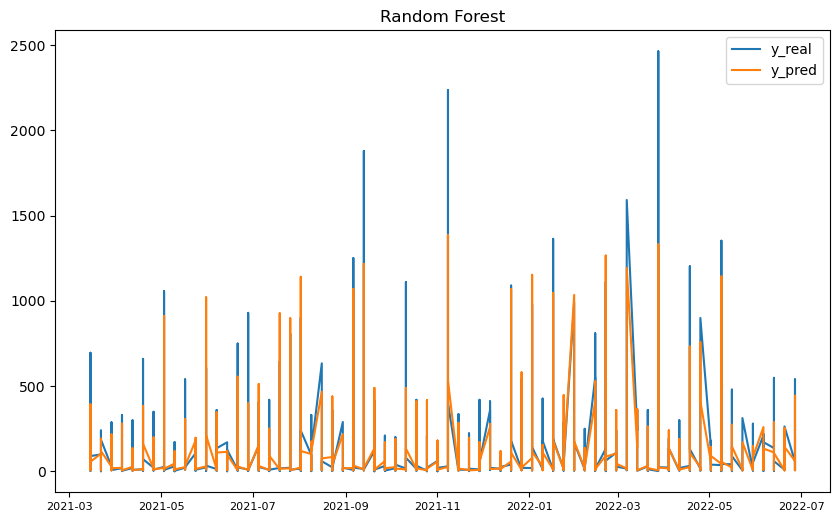

In [34]:
# train_test_split (랜덤)
# 하이퍼파라미터 설정
criterion = 'absolute_error'
max_depth = 10
max_features = 'sqrt'
max_leaf_nodes = 200
n_estimators = 50
random_state = 0

# RandomForestRegressor 모델 생성
rf_model = RandomForestRegressor(
    criterion=criterion,
    max_depth=max_depth,
    max_features=max_features,
    max_leaf_nodes=max_leaf_nodes,
    n_estimators=n_estimators,
    random_state=random_state)

#rf_model = RandomForestRegressor(random_state=11)

rf_model.fit(X_train_df, y_train)

rf_train_pred = rf_model.predict(X_train_df)
rf_valid_pred = rf_model.predict(X_val_df)

train_rmse = mean_squared_error(y_train, rf_train_pred, squared=False)
valid_rmse = mean_squared_error(y_val, rf_valid_pred, squared=False)

print('Train rmse:', train_rmse)
print('Validation rmse:', valid_rmse)
print()
print("훈련 세트 정확도 (r2): {:.3f}".format(rf_model.score(X_train_df, y_train)))
print("테스트 세트 정확도 (r2): {:.3f}".format(rf_model.score(X_val_df, y_val)))

date_w_values = sorted(X_val_df.index.get_level_values('date_w')) # 다중 인덱스라서 추가
plt.figure(figsize=(10, 6))
plt.title('Random Forest')
plt.plot(date_w_values, y_val)
plt.plot(date_w_values, rf_valid_pred) # 모델명
plt.legend(["y_real", "y_pred"])
plt.xticks(fontsize=8)
plt.show()